# 7.4. Авторегрессионные модели (AR-модели)

## 1.1. Введение

В модели множественной регрессии мы прогнозируем интересующую переменную, используя линейную комбинацию предикторов. 

В авторегрессионной модели мы прогнозируем интересующую переменную, используя линейную комбинацию прошлых значений этой переменной. Авторегрессионную модель порядка р или AR(р)-модель можно записать следующим образом:

$$y_t=c+\phi_1y_{t-1}+\phi_2y_{t-2}+...+\phi_py_{t-p}+\epsilon_t$$

где 
- с — константа, 
- $\phi_1, ...,\phi_p$ — параметры модели (авторегрессионные коэффициенты), 
- $\epsilon_t$ — белый шум.

Уравнение похоже на уравнение множественной регрессии, но только с лаговыми значениями $y_t$ в качестве предикторов.
Авторегрессионные модели удивительно гибки при работе с широким спектром различных паттернов временных рядов.

На рисунке ниже показаны AR(1)-модель и AR(2)-модель. Изменение параметров $\phi_1, ...,\phi_p$ приведёт к различным паттернам временных рядов, а вот дисперсия ошибки изменит только масштаб значений временного ряда, но не паттерны временного ряда.

В обоих случаях $\epsilon_t$ — это нормально распределённый белый шум со средним 0 и дисперсией 1.

- AR(1): $y_t=18-0.8y_{t-1}+\epsilon_t$

![image.png](attachment:image.png)

- AR(2): $y_t=8+1.3y_{t-1}-0.7y_{t-2}+\epsilon_t$

![image-2.png](attachment:image-2.png)

Для AR(1)-модели:
- когда $\phi_1 = 0$, $y_t$ эквивалентно белому шуму;
- когда $\phi_1 = 1$ и $c=0$, $y_t$ эквивалентно случайному блужданию;
- когда $\phi_1 = 1$ и $c\ne0$, $y_t$ эквивалентно случайному блужданию с дрейфом;
- когда $\phi_1 < 0$, $y_t$ имеет тенденцию колебаться вокруг среднего значения.

Авторегрессионные модели применяют только для стационарных рядов, и в этом случае требуются некоторые ограничения на значения параметров.

- Для AR(1)-модели: $-1<\phi_1<1$
- Для AR(2)-модели: $-1<\phi_2<1$, $\phi_1+\phi_2<1$, $\phi_2-\phi_1<1$

## 1.2. Иллюстрация применения

Для работы загрузим набор данных FEDFUNDS.csv, содержащий информацию о процентной ставке по федеральным фондам с июля 1954 года по февраль 2021 года. Процентная ставка по федеральным фондам — это ставка, по которой банки США предоставляют в кредит свои избыточные резервы на короткие сроки (как правило, овернайт) другим банкам. Мы будем прогнозировать процентные ставки до финансового кризиса 2008 года.

Давайте импортируем необходимые библиотеки, модули, классы и функции, отключим вывод предупреждений, настроим удобное отображение графиков и таблиц и загрузим данные.

In [ ]:
# Импортируем необходимые библиотеки, классы и функции
import pandas as pd
import numpy as np
from statsmodels.tsa.ar_model import AutoReg
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'

In [ ]:
# Отключаем предупреждения
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Настроим удобное отображение графиков и таблиц
%matplotlib inline
plt.rc('figure', figsize=(18, 3))
pd.set_option('display.float_format', lambda x: '%.2f' % x)
pd.options.display.max_rows = 20

In [ ]:
# Загрузим данные
s = pd.read_csv(
    './data/FEDFUNDS.csv', 
    header=0, 
    index_col=0, 
    parse_dates=True, 
    squeeze=True)

In [ ]:
# Посмотрим на первые пять строк
s.head()

DATE
1954-07-01   0.80
1954-08-01   1.22
1954-09-01   1.07
1954-10-01   0.85
1954-11-01   0.83
Name: FEDFUNDS, dtype: float64

In [ ]:
# Посмотрим на последние пять строк
s.tail()

DATE
2020-10-01   0.09
2020-11-01   0.09
2020-12-01   0.09
2021-01-01   0.09
2021-02-01   0.08
Name: FEDFUNDS, dtype: float64

Визуализируем временной ряд.

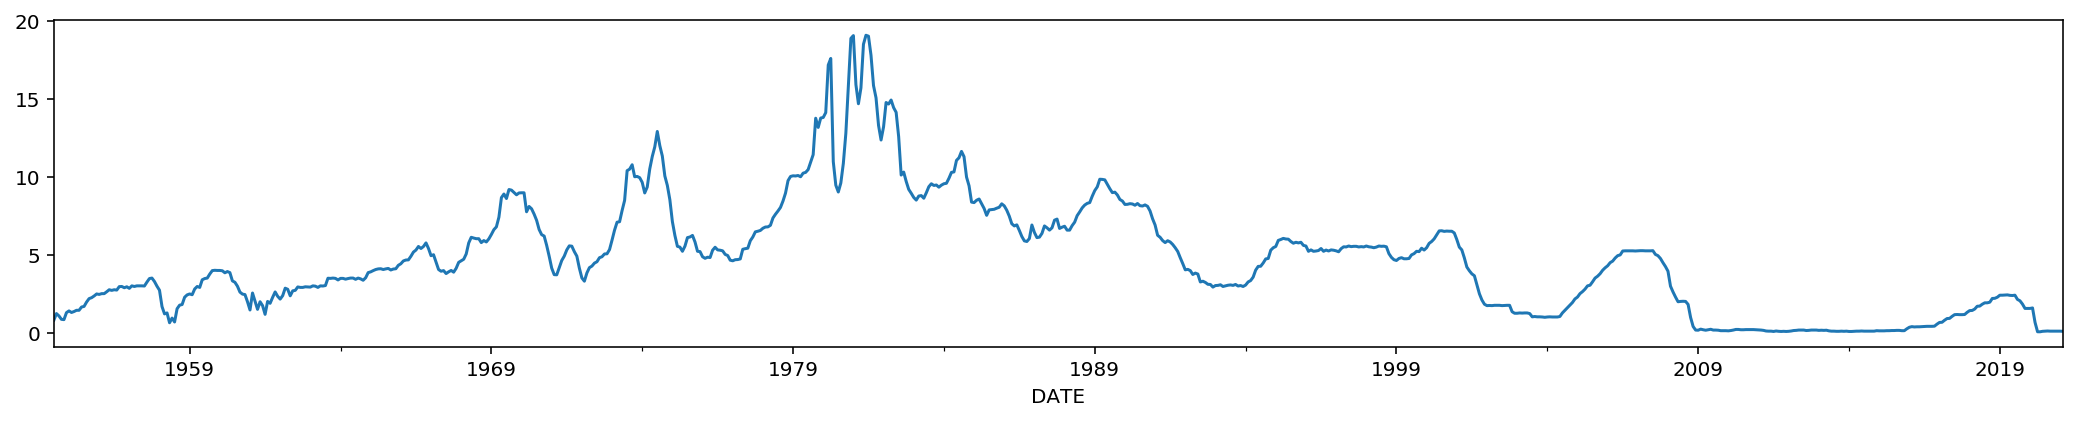

In [ ]:
# Строим график
s.plot();

Оставим данные только до 2008 года.

In [ ]:
# Оставим данные только до 2008 года
s = s[:'2007']

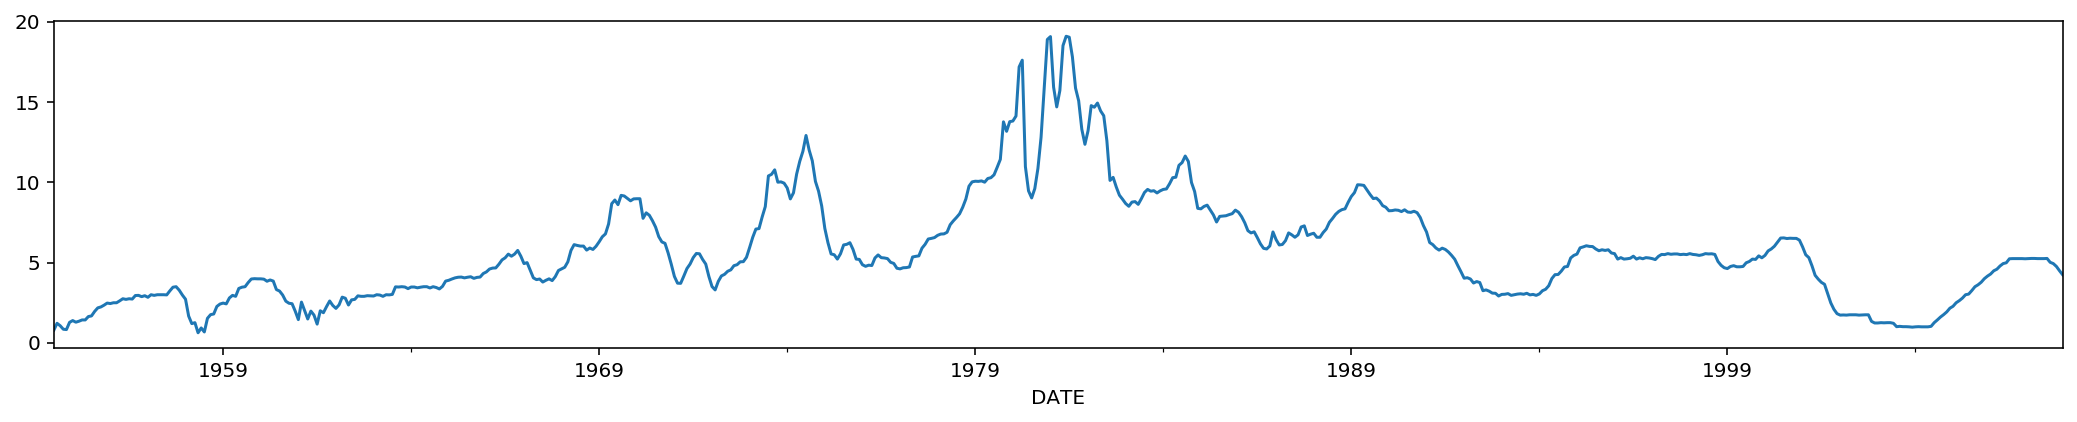

In [ ]:
# Строим график
s.plot();

In [ ]:
# Посмотрим на несколько последних строк временного ряда
s.tail()

DATE
2007-08-01   5.02
2007-09-01   4.94
2007-10-01   4.76
2007-11-01   4.49
2007-12-01   4.24
Name: FEDFUNDS, dtype: float64

In [ ]:
# Оценим длину временного ряда
s.size

642

Разбиваем набор данных на обучающую и тестовую выборки так, чтобы в тестовой выборке оказалось семь наблюдений.

In [ ]:
# Разобьём данные на обучающую и тестовую выборки так,
# чтобы в тесте оказалось семь наблюдений
X = s.values
train, test = X[0:len(X)-7], X[len(X)-7:]

Модель авторегрессии можно построить с помощью класса AutoReg библиотеки Statsmodels.

```python
Class statsmodels.tsa.ar_model.AutoReg(
    endog, #1
    lags, #2
    trnd='c', #3
    seasonal=False, #4
    exog=None, #5
    period=None #6
)
```

- 1. Эндогенная зависимая переменная.
- 2. Количество лагов, если задано целочисленное значение, или список лагов для включения. Например, lags=[1,4] включает лаги 1 и 4, тогда как lags=4 включает 1, 2, 3, 4.
- 3. Тренд для включения в модель.
- 4. Включение сезонных дамми-переменных. Если seasonal=True и trend='c', то первый период исключается из сезонных членов.
- 5. Экзогенные переменные для включения в модель. Должны содержать такое же количество наблюдений, что и endog, для выравнивания и построения модели.
- 6. Период данных. Используется, только когда seasonal=True. Этот параметр можно опустить, если для endog используется объект pandas с заданной частотой.

Теперь обучаем модель авторегрессии на обучающей выборке, задав нужное нам количество лагов.

In [ ]:
# Обучим модель авторегреcсии AutoReg
model = AutoReg(train, lags=3)
model_fit = model.fit()

Давайте выведем сводку о построенной модели.

In [ ]:
# Выведем сводку по модели
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            AutoReg Model Results                             
==============================================================================
Dep. Variable:                      y   No. Observations:                  635
Model:                     AutoReg(3)   Log Likelihood                -457.462
Method:               Conditional MLE   S.D. of innovations              0.499
Date:                Tue, 25 Oct 2022   AIC                            924.925
Time:                        13:46:18   BIC                            947.169
Sample:                             3   HQIC                           933.564
                                  635                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1031      0.040      2.601      0.009       0.025       0.181
y.L1           1.4239      0.039     36.212      0.000       1.347       1.501
y.L2          -0.5885      0.065     -9.080      0.000      -0.716      -0.461
y.L3           0.1474      0.039      3.756      0.000       0.070       0.224
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0251           -0.0000j            1.0251           -0.0000
AR.2            1.4840           -2.1017j            2.5728           -0.1522
AR.3            1.4840           +2.1017j            2.5728            0.1522
-----------------------------------------------------------------------------
"""

Можно вывести константу и коэффициенты модели с помощью атрибута .params.

In [ ]:
# Выведем константу и коэффициенты модели с помощью атрибута .params
coef = model_fit.params
print('Константа и коэффициенты:\n\n%s' % coef)

Константа и коэффициенты:

[ 0.10306775  1.42391855 -0.58848551  0.14737984]


Выведем последние три наблюдения обучающей выборки: 5,26, 5,25 и 5,25. Они соответствуют лаговым переменным у.L3, у.L2 и у.L1. Их ещё можно обозначить $y_{t-3}$, $y_{t-2}$ и $y_{t-1}$. Им соответствуют коэффициенты 0,1474, -0,5885, 1,4239.

In [ ]:
# Выведем последние три наблюдения (для удобства 
# вектор-строку превращаем в вектор-столбец)
obs = train[-3:].reshape(-1, 1)
obs

array([[5.26],
       [5.25],
       [5.25]])

Три наблюдения (три лаговые переменные) составляют скользящее окно размером 3, которое по мере получения нового прогноза обновляется. Каждый раз прогноз становится новым наблюдением (последним наблюдением) окна, и мы сдвигаемся на один шаг вперёд. Взглянем, как получают первый прогноз. Мы просто к константе прибавили произведение значений наблюдений и коэффициентов:

In [ ]:
# Взглянем, как был получен первый прогноз
obs = train[-3:]

forecast_frst = coef[0] + (obs[0] * coef[3]) + (obs[1] * coef[2]) + (obs[2] * coef[1])
forecast_frst

5.264309212500967

Теперь посмотрим, как получают второй прогноз. Первый прогноз встаёт на место последнего, третьего наблюдения, в качестве первого и второго наблюдений используются наблюдения, которые на прошлой итерации были вторым и третьим соответственно.

In [ ]:
# Добавляем прогноз в качестве последнего значения
obs = np.array([5.25, 5.25, forecast_frst]).reshape(-1, 1)
obs

array([[5.25      ],
       [5.25      ],
       [5.26430921]])

In [ ]:
# Взглянем, как был получен второй прогноз
obs = obs.ravel()
forecast_scnd = coef[0] + (
    obs[0] * coef[3]) + (obs[1] * coef[2]) + (obs[2] * coef[1])
forecast_scnd

5.283210567178195

С помощью метода .predict() можно автоматически получить прогнозы. Давайте разберём параметры метода .predict() класса AutoReg.

```python
AutoReg.predict(
    params, #1
    start=None, #2
    end=None, #3
    dynamic=False #4
)
```

- 1. Параметры.
- 2. Номер наблюдения, с которого нужно начать прогнозирование, то есть первый прогноз, с которого нужно начать (нумерация начинается с нуля).
- 3. Номер наблюдения, которым нужно завершить прогнозирование, то есть последний прогноз, которым нужно закончить (нумерация начинается с нуля).
- 4. Целочисленное смещение относительно start, с которого следует начать динамическое прогнозирование.

Давайте получим прогнозы на неделю вперёд, для этого в методе .predict() задаём начало и конец периода прогнозирования.

In [ ]:
# Делаем прогнозы на семь временных шагов вперёд,
# для этого в методе .predict() задаём начало и конец 
# периода прогнозирования
predictions = model_fit.predict(
    start=len(train), end=len(train)+len(test)-1, dynamic=False)

In [ ]:
# Напечатаем прогнозы на неделю вперёд
for i in range(len(predictions)):
    print('спрогнозированное=%f, фактическое=%f' % (predictions[i], test[i]))

спрогнозированное=5.264309, фактическое=5.250000
спрогнозированное=5.283211, фактическое=5.260000
спрогнозированное=5.301704, фактическое=5.020000
спрогнозированное=5.319022, фактическое=4.940000
спрогнозированное=5.335585, фактическое=4.760000
спрогнозированное=5.351703, фактическое=4.490000
спрогнозированное=5.367459, фактическое=4.240000


In [ ]:
# Вычислим значение метрики RMSE
rmse = np.sqrt(
    mean_squared_error(test, predictions))
print('\nRMSE на тестовой выборке: %.3f' % rmse)


RMSE на тестовой выборке: 0.606


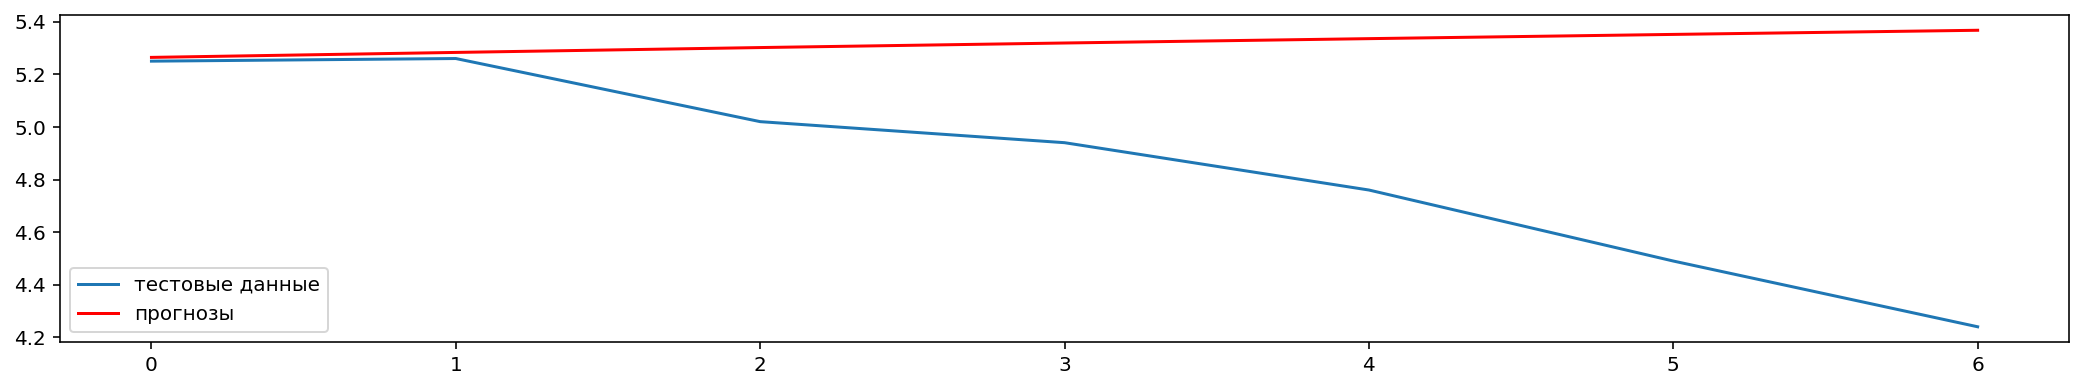

In [ ]:
# Визуализируем прогнозы
plt.plot(test, label='тестовые данные')
plt.plot(predictions, color='red', label='прогнозы')
plt.legend();

API библиотеки Statsmodels не предлагает удобных способов обновления (повторного обучения) модели по мере появления новых наблюдений, хотя повторное обучение модели каждый день по мере появления новых наблюдений при условии небольшого размера обучающей выборки может быть вполне адекватным подходом. Мы можем воспользоваться коэффициентами и получить прогнозы вручную. Для этого требуется, чтобы у нас были сохранены nlags последних наблюдений (nlags — количество лагов авторегрессионной модели), а коэффициенты извлекались из модели и использовались в уравнении авторегрессии для создания новых прогнозов. Здесь на место последнего наблюдения скользящего окна встаёт уже не прогноз, а наблюдение тестовой выборки.

In [ ]:
# Сохраним количество лагов модели авторегрессии 
window = 3

# Сохраним коэффициенты модели авторегрессии 
coef = model_fit.params

# Зададим начало для скользящего окна, размер скользящего окна 
# (количество лаговых переменных) взят из обученной ранее модели
history = train[len(train) - window:]
history = [history[i] for i in range(len(history))]

# В пустой список predictions будем сохранять прогнозы
predictions = []

# Для каждого наблюдения в тестовой выборке
for t in range(len(test)):
    # зададим длину обучающей выборки
    length = len(history)
    # запишем значения наблюдений, которые попали в скользящее окно
    # (значения лаговых переменных), длина обучающей выборки
    # будет увеличиваться на 1, и начало окна будет сдвигаться на 1
    print('Начало скользящего окна:', length - window)
    lag = [history[i] for i in range(length - window, length)]
    print('Наблюдения в скользящем окне:', lag)
    # в качестве базового прогноза укажем intercept модели авторегрессии
    yhat = coef[0]
    print('Базовый прогноз (константа): ', yhat)
    
    # затем каждое значение лага в скользящем окне умножаем 
    # на соответствующий коэффициент (первое значение в coef 
    # не используем, потому что оно соответствует константе,
    # последнее значение в скользящем окне соответствует первому 
    # коэффициенту, не считая константы), результаты суммируем 
    # и добавляем к базовому прогнозу, обновляя прогноз
    for d in range(window):
        yhat += coef[d+1] * lag[window-d-1]
    print('Обновлённый прогноз: ', yhat)
        
    # записываем текущее наблюдение
    obs = test[t]
    print('Фактическое значение = ', obs)
    # добавляем полученный прогноз в список прогнозов 
    predictions.append(yhat)
    print('Количество предсказанных наблюдений: ', len(predictions))
    # добавляем текущее наблюдение в историю, чтобы 
    # сместить начало скользящего окна
    history.append(obs)
    print('Набл. тестовой выборки со значением {}\n'.format(obs) + 
          'попадает в обучающую выборку\n')

# Вычислим метрику качества RMSE
rmse = np.sqrt(mean_squared_error(test, predictions))
print('\nRMSE на тестовой выборке: %.3f' % rmse)

Начало скользящего окна: 0
Наблюдения в скользящем окне: [5.26, 5.25, 5.25]
Базовый прогноз (константа):  0.10306775130470935
Обновленный прогноз:  5.264309212500967
Фактическое значение =  5.25
Количество предсказанных наблюдений:  1
Набл. тестовой выборки со значением 5.25
попадает в обучающую выборку

Начало скользящего окна: 1
Наблюдения в скользящем окне: [5.25, 5.25, 5.25]
Базовый прогноз (константа):  0.10306775130470935
Обновленный прогноз:  5.26283541406245
Фактическое значение =  5.26
Количество предсказанных наблюдений:  2
Набл. тестовой выборки со значением 5.26
попадает в обучающую выборку

Начало скользящего окна: 2
Наблюдения в скользящем окне: [5.25, 5.25, 5.26]
Базовый прогноз (константа):  0.10306775130470935
Обновленный прогноз:  5.277074599562257
Фактическое значение =  5.02
Количество предсказанных наблюдений:  3
Набл. тестовой выборки со значением 5.02
попадает в обучающую выборку

Начало скользящего окна: 3
Наблюдения в скользящем окне: [5.25, 5.26, 5.02]
Базовый

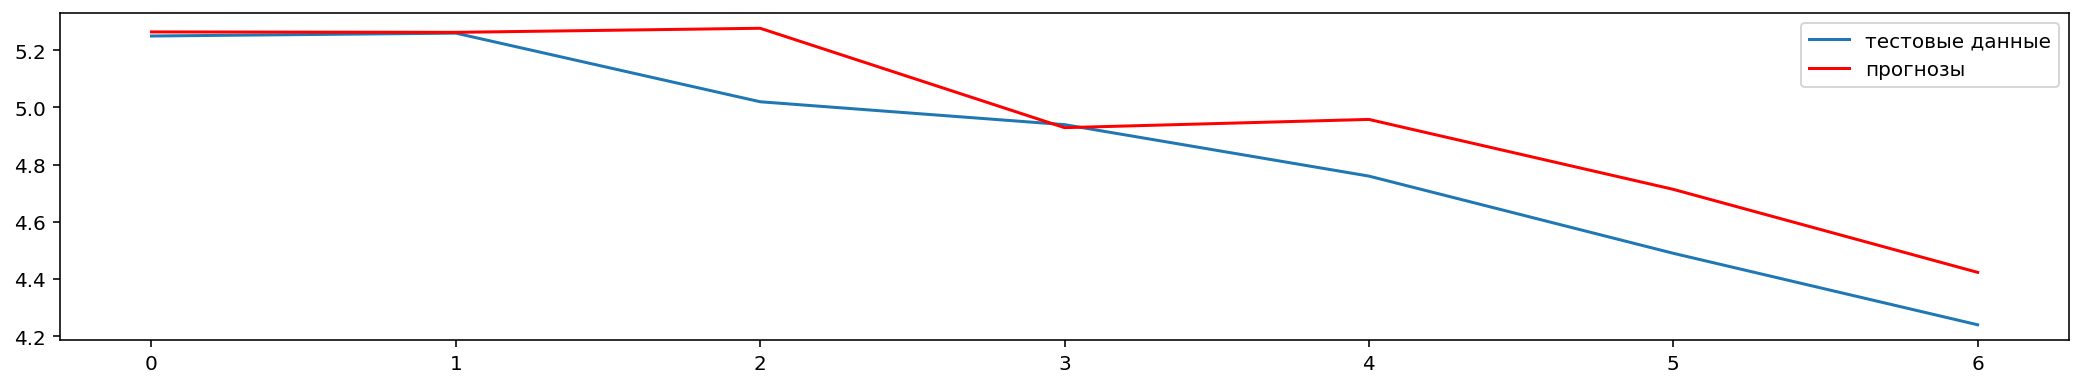

In [ ]:
# Визуализируем прогнозы
plt.plot(test, label='тестовые данные')
plt.plot(predictions, color='red', label='прогнозы')
plt.legend();